In [1]:
import pandas as pd
import numpy as np

In [2]:
# Funkce pro odstranění odlehlých hodnot

def replaceOutliers(table):
    # odstraňování odlehlých hodnot
    for column in table.columns:
        # Výpočet mediánu pro daný sloupec
        median_value = table[column].median()

        # Počet směrodatných odchylek od mediánu
        num_std_dev = 3

        # Výpočet spodní a vrchní hranice s použitím násobku směrodatné odchylky a mediánu
        lower_bound = median_value - num_std_dev * table[column].std()
        upper_bound = median_value + num_std_dev * table[column].std()

        # Nahrazení odlehlých hodnot hodnotami NaN
        table.loc[table[column]<lower_bound, column] = np.nan
        table.loc[table[column]>upper_bound, column] = np.nan

    return table

In [20]:
# Funkce pro odstranění sloupců, které mají určité procento NaN

def dropColumnsWithTooManyNaNs(table, percentage=0.25):
    # Odstranění sloupců, které mají počet NaN hodnot větší, než 25 % celkového počtu řádků

    dropList = [] # list sloupců, které mají více jak 20000 NaN hodnot

    for column in table.columns:
        if table[column].isnull().sum() > (table.shape[0]*percentage):
            dropList.append(column)

    filteredTable = table.drop(columns=dropList)  

    return filteredTable

# Načtení datasetu

In [74]:
# Cesta k tabulce s pacienty
filepath = './dataSepsis.csv'

# Načtení celé tabulky
fullSepsis = pd.read_csv(filepath, sep=';')

# Histogram pro zobrazení zastoupení NaN v jednotlivých features

<Axes: >

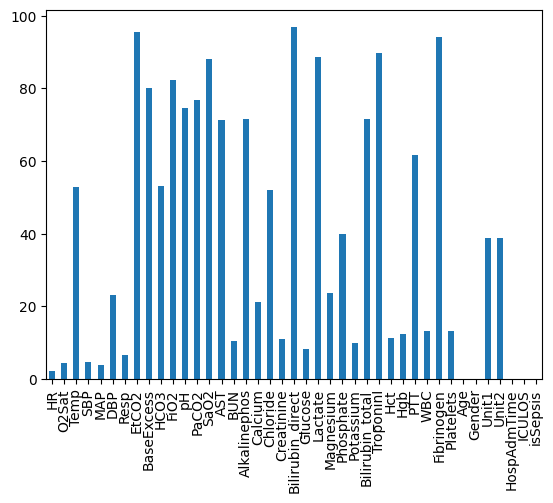

In [75]:
# Procentuální zastoupení NaN v datasetu (vztaženo na počet řádků)
NaN_percentage = (fullSepsis.isnull().sum()/fullSepsis.shape[0])*100
NaN_percentage.plot(kind="bar")


# Odstranění sloupců s příliš mnoha NaN

In [76]:
relevantFullSepsis = dropColumnsWithTooManyNaNs(fullSepsis)

In [80]:
((relevantFullSepsis.isnull().sum()/relevantFullSepsis.shape[0])*100)

HR              2.192717
O2Sat           4.313812
SBP             4.641618
MAP             4.010798
DBP            23.097901
Resp            6.644262
BUN            10.401631
Calcium        21.153105
Creatinine     11.134373
Glucose         8.387968
Magnesium      23.775550
Potassium       9.897526
Hct            11.354746
Hgb            12.357446
WBC            13.338108
Platelets      13.313316
Age             0.000000
Gender          0.000000
HospAdmTime     0.000000
ICULOS          0.000000
isSepsis        0.000000
dtype: float64

# Heatmapa pro zobrazení korelace jednotlivých features mezi sebou 

<Axes: >

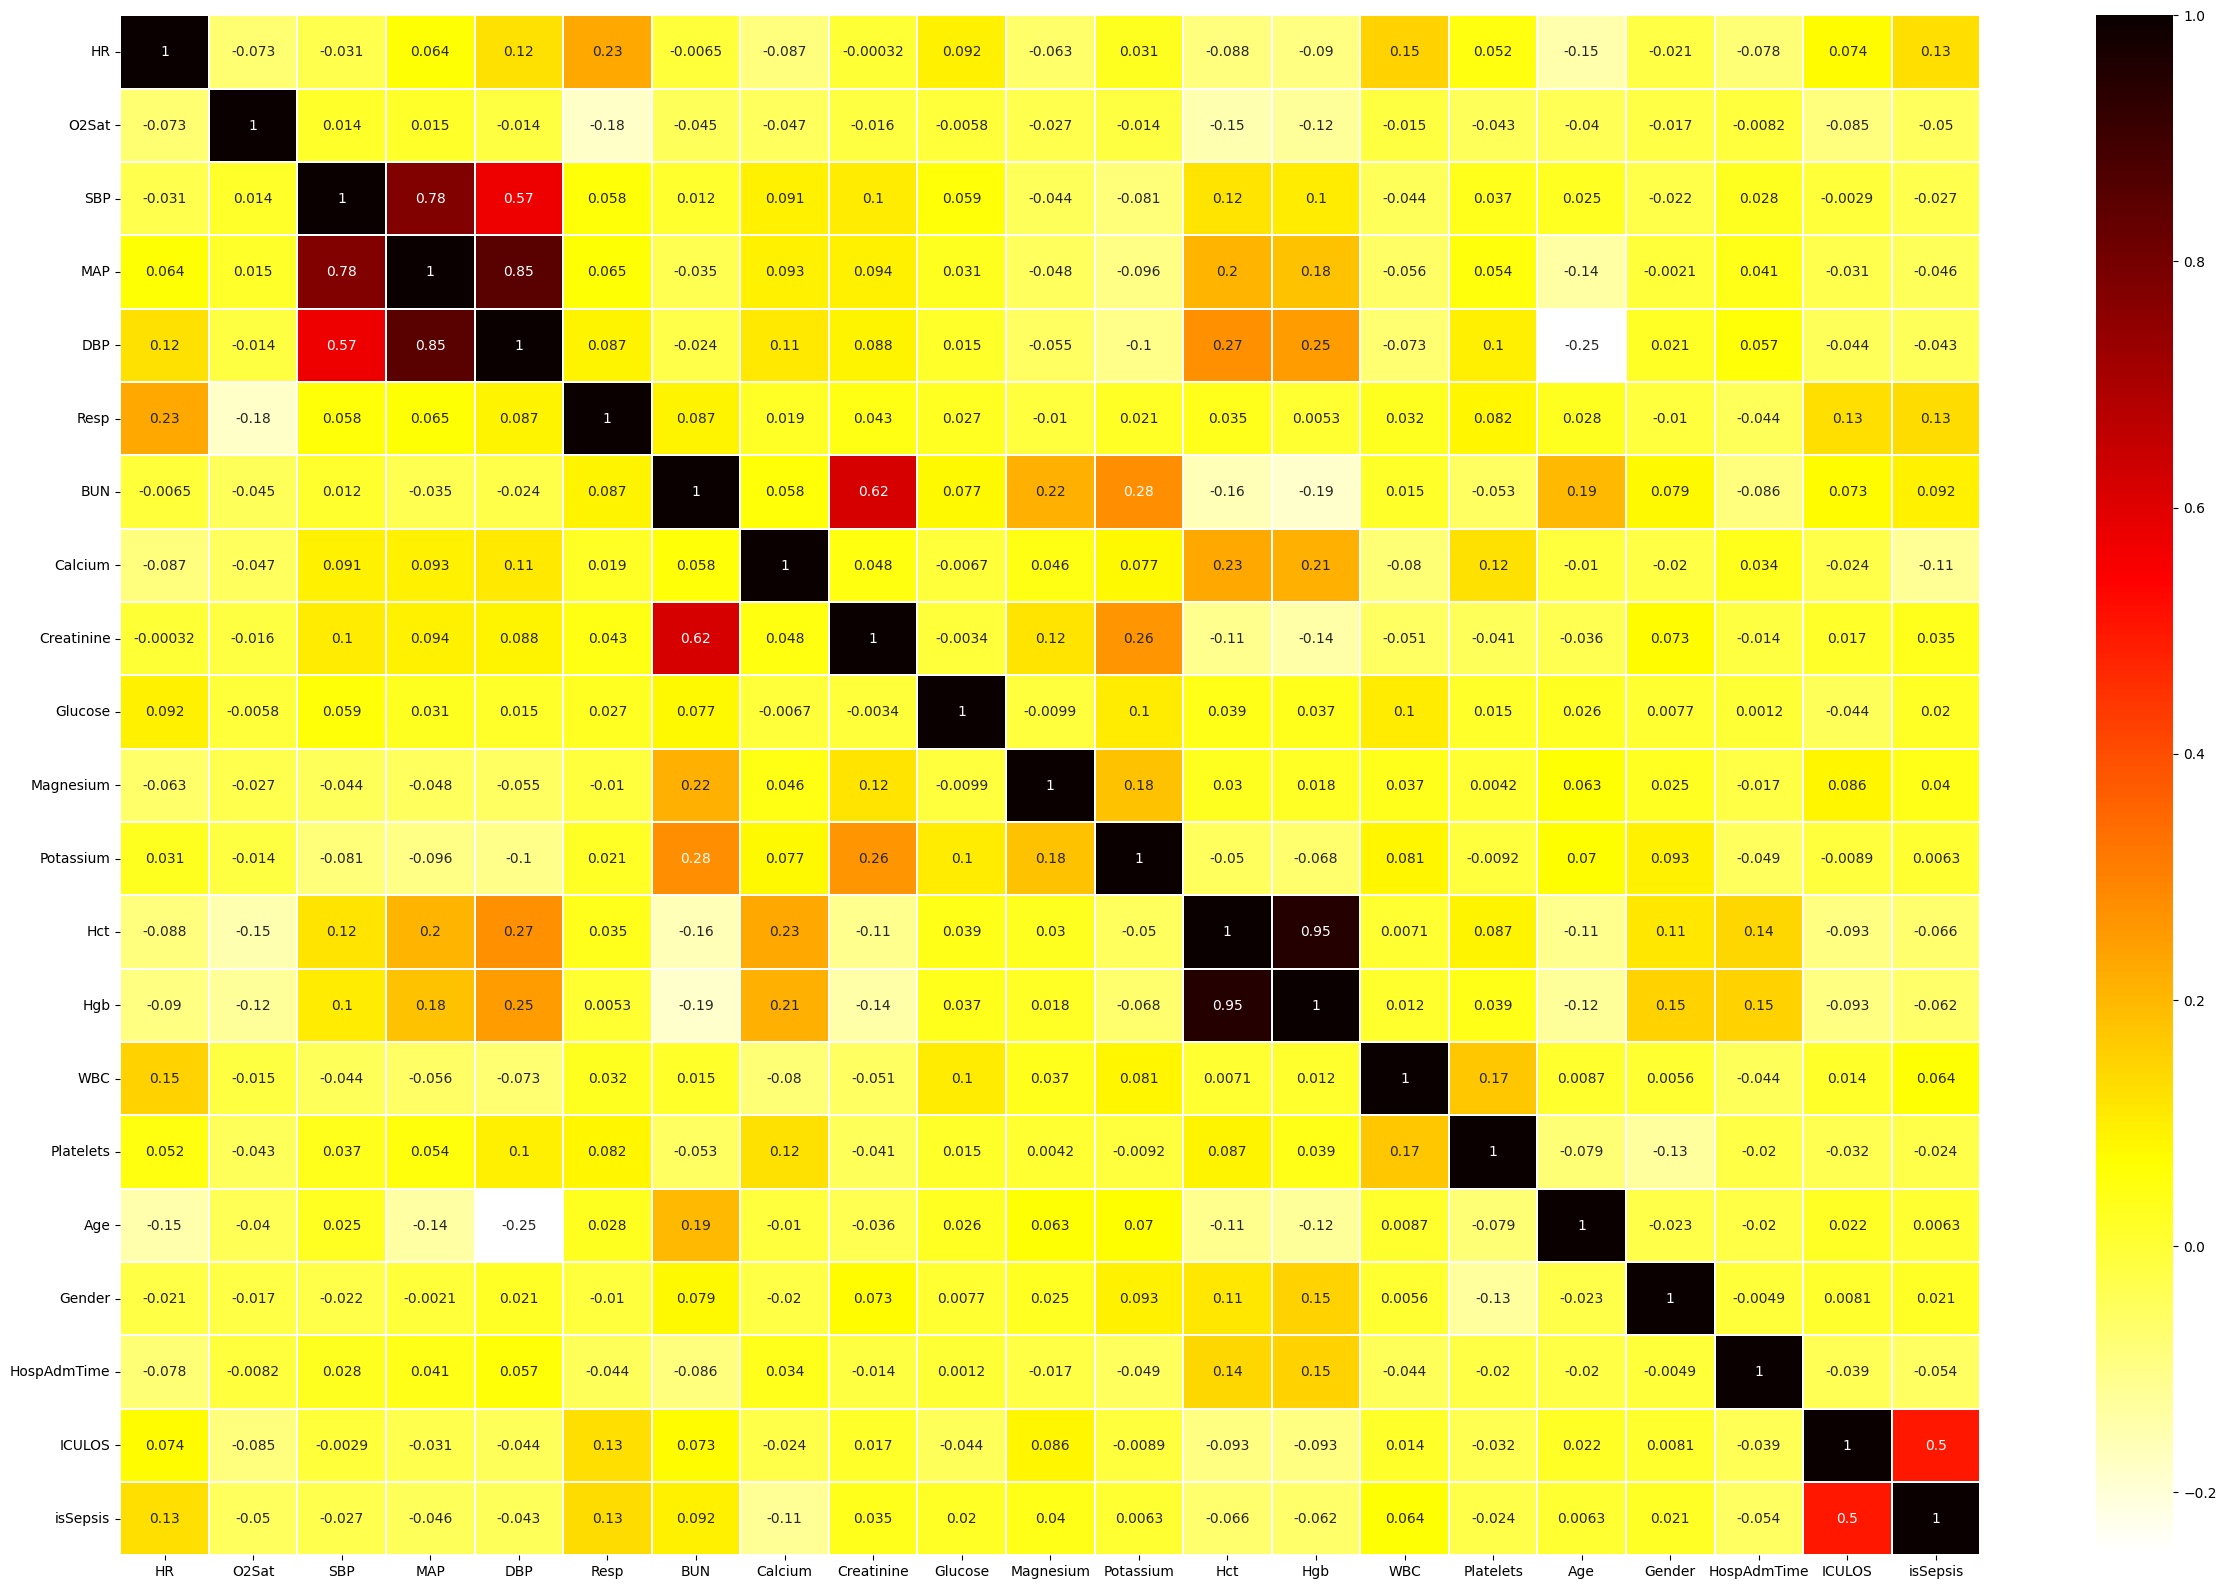

In [73]:
import seaborn as sb
corr = relevantFullSepsis.corr(method="pearson")

fig, ax = plt.subplots(figsize=(30, 20))
sb.heatmap(corr, cmap="hot_r", annot=True, linewidths=0.3)

# Odstranění přebytečných sloupců na základě korelace

In [81]:
relevantFullSepsis = relevantFullSepsis.drop(columns=["Hct", "SBP", "DBP"])

In [82]:
# Rozdělení tabulky do dvou datasetů
sepsis0 = relevantFullSepsis[relevantFullSepsis["isSepsis"] == 0] # dataset pacientů bez sepse (0)
sepsis1 = relevantFullSepsis[relevantFullSepsis["isSepsis"] == 1] # dataset pacientů se sepsí (1)

# Předzpracování datasetu s pacienty bez sepse

In [30]:
relevantSepsis0 = replaceOutliers(sepsis0)
# odstranění řádků, které mají 1 a více NaN
relevantSepsis0 = relevantSepsis0.dropna()


# Předzpracování datasetu s pacienty se sepsí 

In [108]:
relevantSepsis1 = replaceOutliers(sepsis1)
filtered_sepsis1 = relevantSepsis1.dropna(thresh=relevantSepsis1.shape[1]-6)
filledSepsis1 = filtered_sepsis1.ffill(axis=0)
filledSepsis1.dropna(inplace=True)
filledSepsis1

,HR,O2Sat,MAP,Resp,BUN,Calcium,Creatinine,Glucose,Magnesium,Potassium,Hgb,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,isSepsis
8,89.0,100.0,85.00,17.0,9.0,8.4,0.70,137.0,2.5,3.5,11.2,10.6,184.0,65.79,1.0,-0.02,35.0,1.0
47,93.0,94.0,90.00,16.0,9.0,7.5,0.70,141.0,1.8,4.3,7.4,15.4,167.0,68.20,1.0,-0.02,7.0,1.0
55,86.0,100.0,74.00,21.0,27.0,7.7,1.10,181.0,2.5,4.6,8.6,10.8,136.0,68.98,0.0,-0.01,29.0,1.0
67,135.0,100.0,53.33,14.0,19.0,7.5,0.70,181.0,2.2,3.7,8.8,23.3,246.0,56.97,1.0,-0.01,101.0,1.0
156,95.0,98.0,102.00,15.0,19.0,8.1,0.60,134.0,2.3,3.8,8.7,10.6,284.0,43.43,1.0,-0.02,96.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36027,87.0,95.5,104.50,20.0,12.0,10.3,1.30,159.0,2.2,4.4,9.6,10.7,252.0,45.00,1.0,-0.05,44.0,1.0
36045,125.5,99.5,56.00,15.0,12.0,8.0,1.30,181.0,2.2,4.7,10.4,21.7,126.0,81.00,1.0,-0.05,13.0,1.0
36086,74.0,96.0,79.00,15.0,23.0,8.3,0.66,132.0,1.9,3.1,9.4,16.0,435.0,50.00,0.0,-0.05,13.0,1.0
36114,86.0,95.0,103.00,28.0,23.0,7.9,0.70,134.0,2.1,3.6,9.5,15.8,239.0,72.00,0.0,-0.01,9.0,1.0


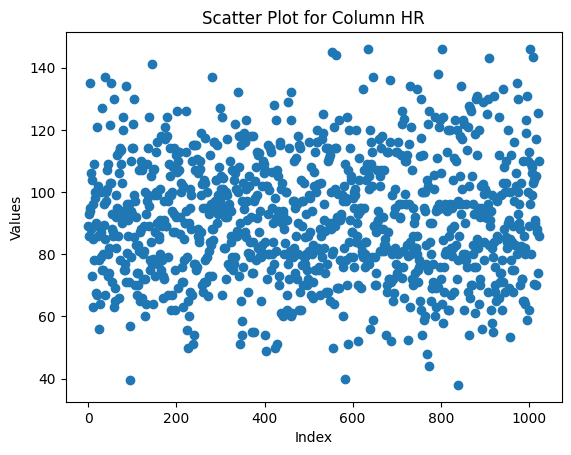

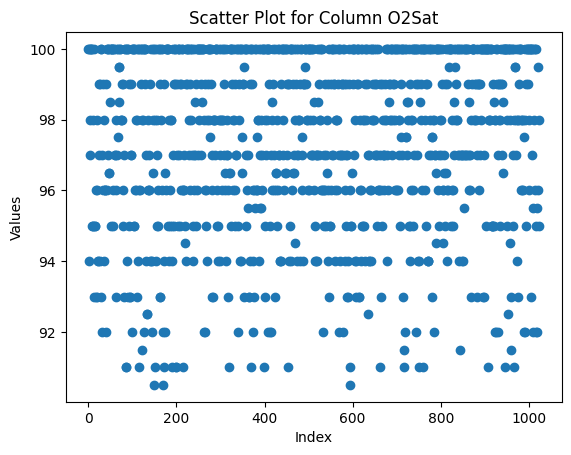

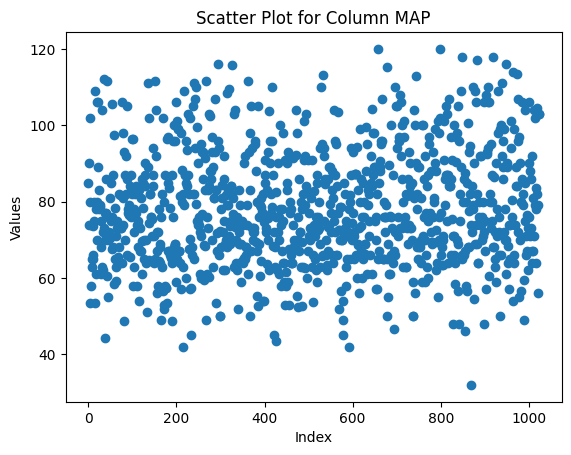

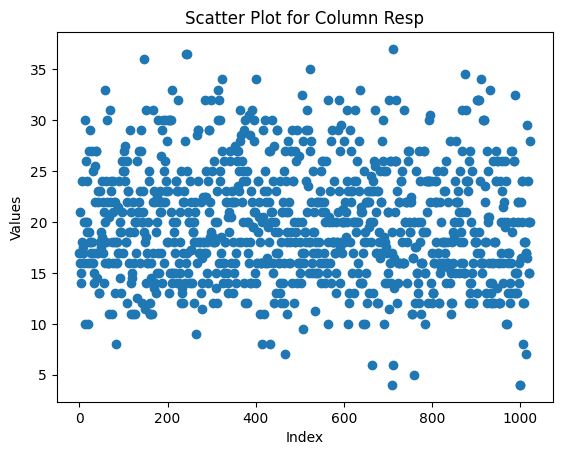

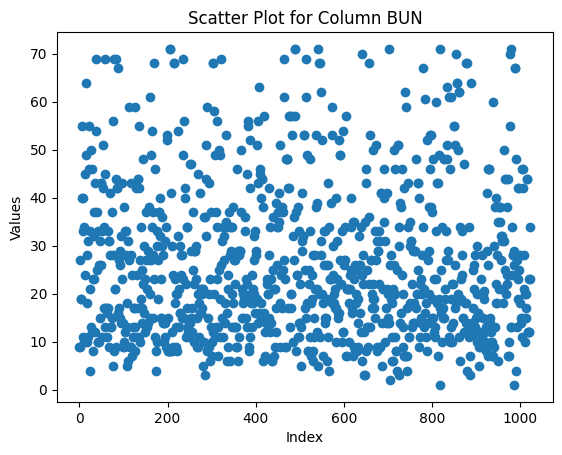

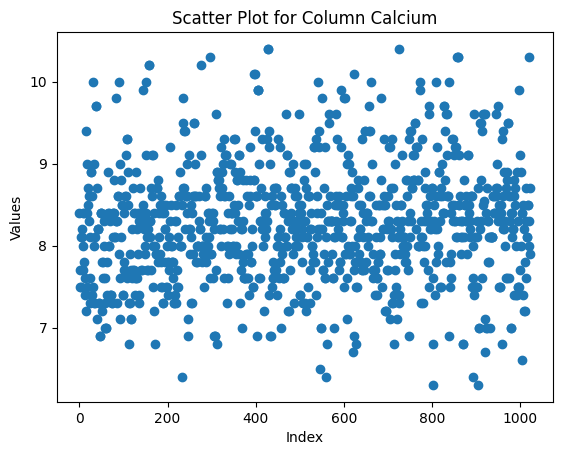

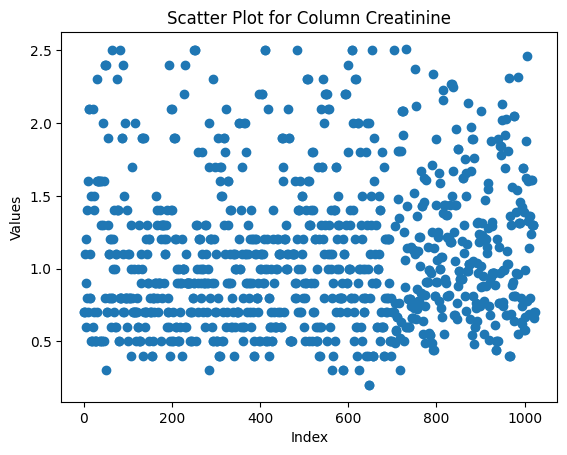

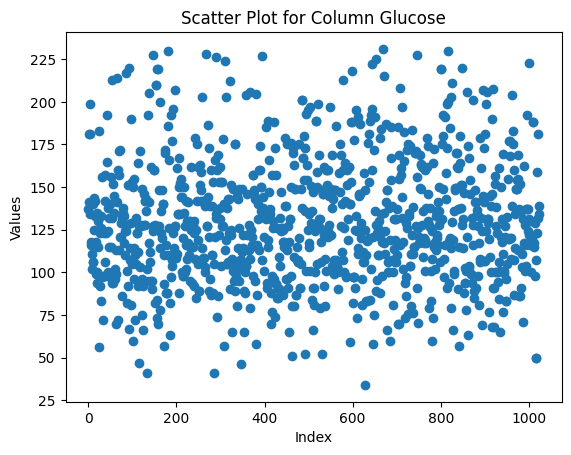

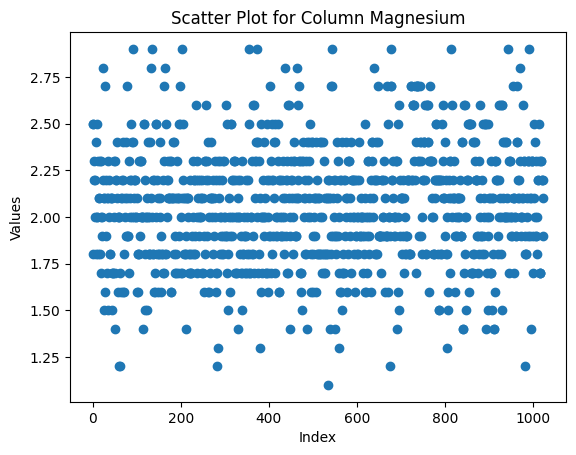

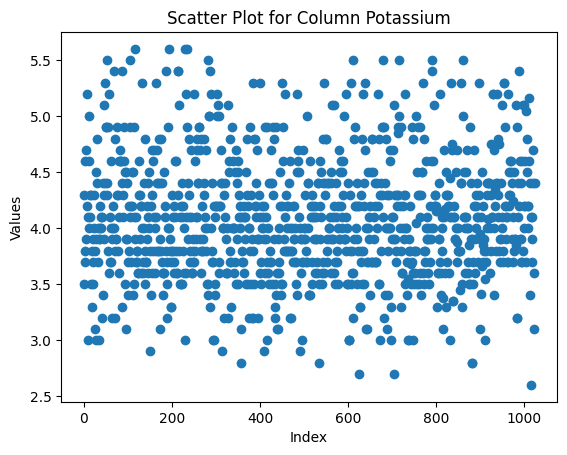

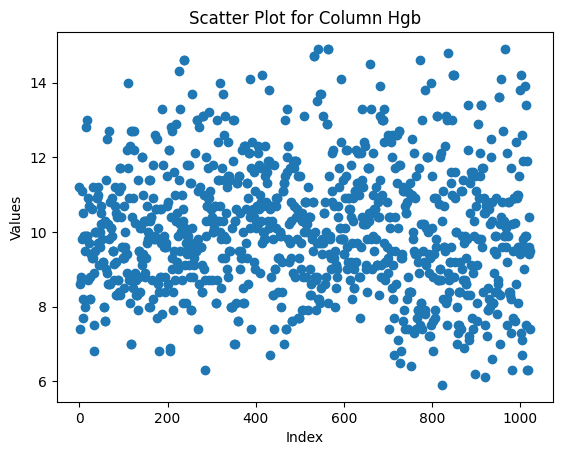

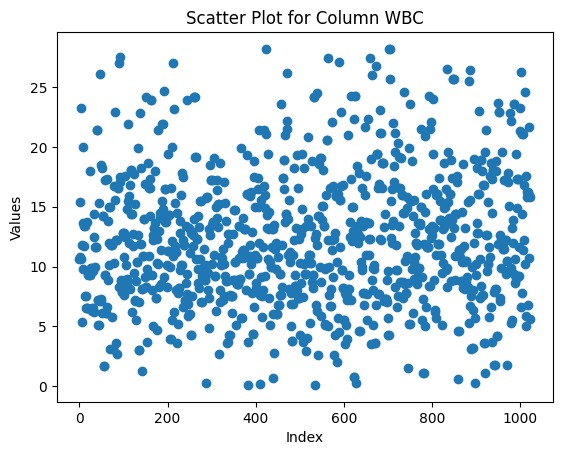

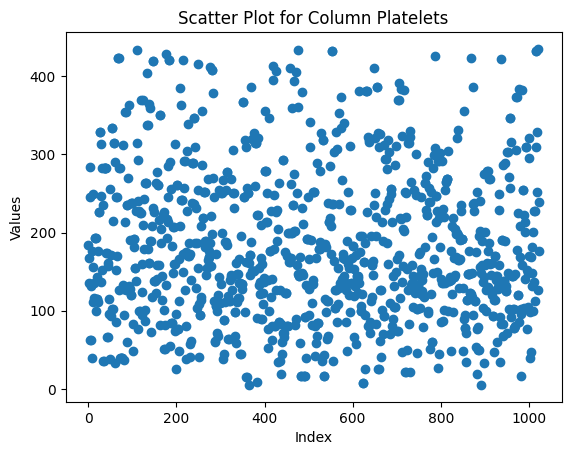

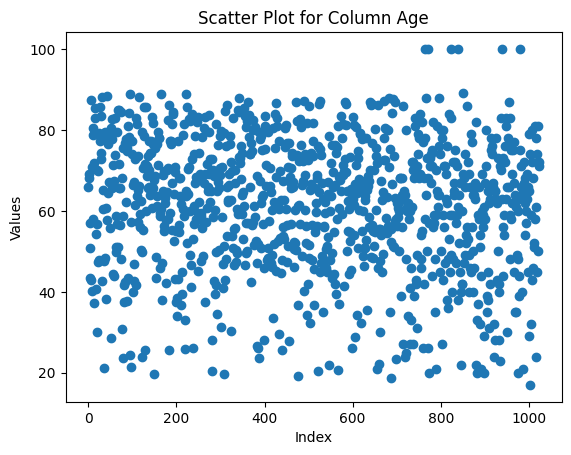

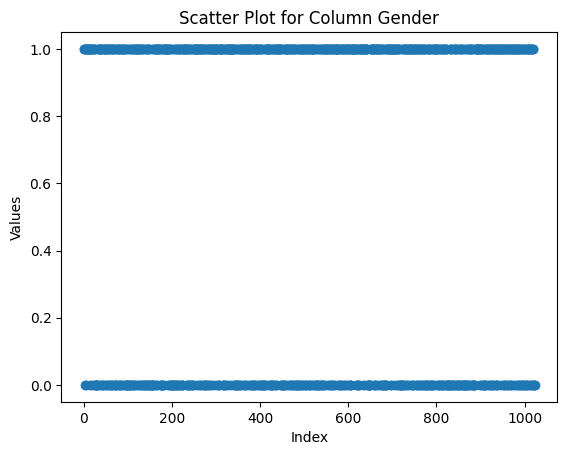

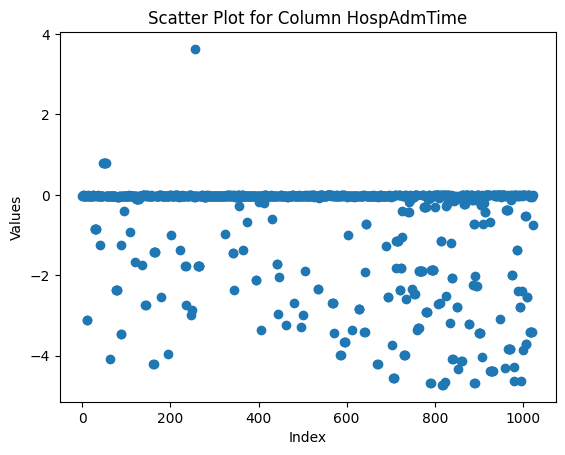

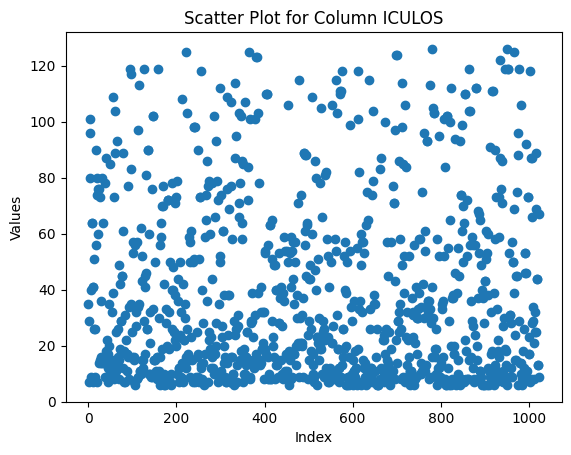

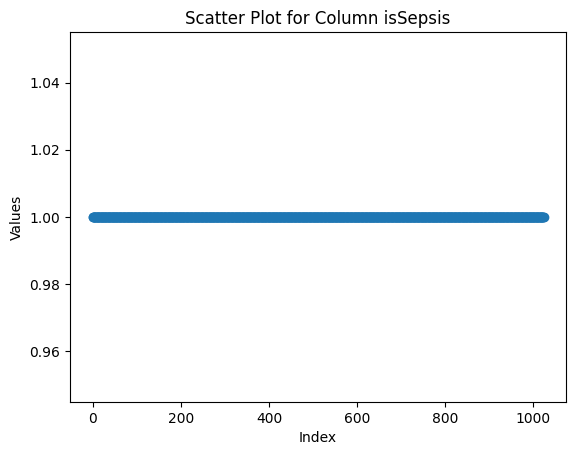

In [104]:
import matplotlib.pyplot as plt

# Create individual scatter plots for each column
for column in filledSepsis1.columns:
    plt.figure()  # Create a new figure for each scatter plot
    plt.scatter(range(len(filledSepsis1[column])), filledSepsis1[column])
    plt.title(f'Scatter Plot for Column {column}')
    plt.xlabel('Index')
    plt.ylabel('Values')

plt.show()

